In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline


In [44]:
def conll_sentences(conll_file):
    sent = []
    pos = []
    chunk = []
    entity = []
    temp_sent = []
    temp_pos = []
    temp_chunk = []
    temp_entity = []
    
    with open(conll_file) as f:
        conll_raw_data = f.readlines()
    conll_raw_data = [x.strip() for x in conll_raw_data]

    for line in conll_raw_data:
        if line != '':
            split_line = line.split()
            if len(split_line) == 4:
                if split_line[0] != '-DOCSTART-':
                    temp_sent.append(split_line[0])
                    temp_pos.append(split_line[1])
                    temp_chunk.append(split_line[2])
                    
                    # Rename entity values as PER, LOC, ORG, MISC, O
                    old_ent = split_line[3]
                    if old_ent in ('I-ORG', 'B-ORG'):
                        new_ent = 'ORG'
                    elif old_ent in ('I-LOC', 'B-LOC'):
                        new_ent = 'LOC'
                    elif old_ent in ('I-MISC', 'B-MISC'):
                        new_ent = 'MISC'
                    elif old_ent in ('I-PER', 'B-PER'):
                        new_ent = 'PER'
                    else:
                        new_ent = 'O'
                    temp_entity.append(new_ent)
            else:
                raise IndexError('Line split length does not equal 4.')
        else:
            if len(temp_sent) > 0:
                assert(len(sent) == len(pos))
                assert(len(sent) == len(chunk))
                assert(len(sent) == len(entity))
                sent.append(temp_sent)
                pos.append(temp_pos)
                chunk.append(temp_chunk)
                entity.append(temp_entity)
                temp_sent = []
                temp_pos = []
                temp_chunk = []
                temp_entity = []
    
    return sent, pos, chunk, entity

In [45]:
def conll_words(conll_file):
    all_words = []
    all_pos = []
    all_chunk = []
    all_entities = []
    
    sent, pos, chunk, entity = conll_sentences(conll_file)

    for se in sent:
        for w in se:
            all_words.append(w)
    for po in pos:
        for p in po:
            all_pos.append(p)
    for ch in chunk:
        for c in ch:
            all_chunk.append(c)
    for en in entity:
        for e in en:
            all_entities.append(e)
            
    return all_words, all_pos, all_chunk, all_entities

In [46]:
train_file = r"/content/drive/MyDrive/Dataset/NER_Dataset/CoNLL2003/eng.train"
testa_file = r"/content/drive/MyDrive/Dataset/NER_Dataset/CoNLL2003/eng.testa"
testb_file = r"/content/drive/MyDrive/Dataset/NER_Dataset/CoNLL2003/eng.testb"
testc_file = r"/content/drive/MyDrive/Dataset/NER_Dataset/CoNLL2003/eng.testc"

train_words, train_pos, train_chunk, train_entity = conll_words(train_file)
testa_words, testa_pos, testa_chunk, testa_entity = conll_words(testa_file)
testb_words, testb_pos, testb_chunk, testb_entity = conll_words(testb_file)
testc_words, testc_pos, testc_chunk, testc_entity = conll_words(testc_file)


In [47]:
combined_words = train_words + testa_words + testb_words + testc_words

In [48]:
print(len(train_words))
print(len(testa_words))
print(len(testb_words))
print(len(testc_words))
print(len(combined_words))

203621
51362
46435
35
301453


In [49]:
char_set = set()
char_dict = {}
max_word_len = 0

for word in combined_words:
  if len(word) > max_word_len:
    max_word_len = len(word)

  for char in word:
    char_set.add(char)

for i, char in enumerate(char_set):
  char_dict[char] = int(i)+1

for key in char_dict.keys():
  if char_dict[key] == 0:
    raise KeyError("ERROR: index 0 is used with key:", key)

print("Maximum word lentgh: ", max_word_len)
print("Char set lentgh: ", len(char_dict))

Maximum word lentgh:  61
Char set lentgh:  85


### Convert training and test words into padded int vectors using char dictonary

In [50]:
train_sentence, _, _, _ = conll_sentences(train_file)

train_sentence[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [51]:
from gensim.models import Word2Vec

w2v_model = Word2Vec()
w2v_model.build_vocab(train_sentence)
w2v_model.train(train_sentence, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

#w2v_model.save("word2vec.model")

(3850250, 6108630)

In [52]:
# from sklearn.decomposition import PCA
# from matplotlib import pyplot as plt

# X = w2v_model[w2v_model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)

# plt.scatter(result[:, 0], result[:, 1])
# words = list(w2v_model.wv.vocab)
# for i, word in enumerate(words):
# 	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
# plt.show()

In [53]:
def word2vec(words):
  out = []
  for word in words:
    temp = []
    for char in word:
      temp.append(char_dict[char])
    
    out.append(temp)

  return np.array(out)

In [54]:
from keras.preprocessing import sequence

maxlen = 70

train_words = sequence.pad_sequences(word2vec(train_words), maxlen=maxlen)
testa_words = sequence.pad_sequences(word2vec(testa_words), maxlen=maxlen)
testb_words = sequence.pad_sequences(word2vec(testb_words), maxlen=maxlen)
testc_words = sequence.pad_sequences(word2vec(testc_words), maxlen=maxlen)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [55]:
labels = np.unique(train_entity)
labels

array(['LOC', 'MISC', 'O', 'ORG', 'PER'], dtype='<U4')

In [56]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_entity),
                                                 y=train_entity)

class_weights = {k: v for k,v in enumerate(class_weights)}
class_weights

{0: 4.908304206339641,
 1: 8.866579577618115,
 2: 0.24015025533972567,
 3: 4.06226433915212,
 4: 3.6596153846153845}

In [57]:
def one_hot_encode_fit(labels, entities):
  label_to_int = dict((c, i) for i, c in enumerate(labels))
  int_to_label = dict((i, c) for i, c in enumerate(labels))

  return label_to_int, int_to_label


def one_hot_encode_transform(labels, label_to_int, entities):
  integer_encoded = [label_to_int[char] for char in entities]
  onehot_encoded = list()
  for value in integer_encoded:
    letter = [0 for _ in range(len(labels))]
    letter[value] = 1
    onehot_encoded.append(letter)

  return np.array(onehot_encoded)


def one_hot_encode_reverse(labels, int_to_label, encoded_entities):
    entities = [e.argmax() for e in encoded_entities]
    entities = [int_to_label[x] for x in entities]  

    return np.array(entities)

In [58]:
label_to_int, int_to_label = one_hot_encode_fit(labels, train_entity)

train_entities = one_hot_encode_transform(labels, label_to_int, train_entity)
testa_entities = one_hot_encode_transform(labels, label_to_int, testa_entity)
testb_entities = one_hot_encode_transform(labels, label_to_int, testb_entity)
testc_entities = one_hot_encode_transform(labels, label_to_int, testc_entity)

In [59]:
int_to_label, label_to_int

({0: 'LOC', 1: 'MISC', 2: 'O', 3: 'ORG', 4: 'PER'},
 {'LOC': 0, 'MISC': 1, 'O': 2, 'ORG': 3, 'PER': 4})

In [79]:
def accuracy (expected, predicted):
    total = 0
    correct = 0
    for i in range(len(expected)):
        total += 1
        if (expected[i] == predicted[i]):
            correct += 1
    print('accuracy = %d / %d = %lf' % (correct, total, correct/total))

In [80]:
def entity_count (expected):

    n_org = 0
    n_per = 0
    n_loc = 0
    n_misc = 0
    n_o = 0
    
    for e in expected:
        if e == 'ORG':
            n_org = n_org + 1
        elif e == 'PER':
            n_per = n_per + 1
        elif e == 'LOC':
            n_loc = n_loc + 1
        elif e == 'MISC':
            n_misc = n_misc + 1
        elif e == 'O':
            n_o = n_o + 1
    
    print('ORG:', n_org)
    print('PER:', n_per)
    print('LOC:', n_loc)
    print('MISC:', n_misc)
    print('O:', n_o)

In [81]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn
import pandas as pd


def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))

    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))
    
    print()
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i for i in label_encoder.keys()],
                  columns = [i for i in label_encoder.keys()])
    plt.figure(figsize = (10,10))
    sn.heatmap(df_cm, annot=True)

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder.keys()))

In [82]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def ROC_plot(y_true_ohe, y_hat_ohe, label_encoder, n_classes):    
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_ohe[:, i], y_hat_ohe[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
                                  
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ohe.ravel(), y_hat_ohe.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(20,20))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(list(label_encoder.keys())[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Classes Characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [61]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [62]:
max_features = len(char_set) + 1
batch_size = 256
epochs = 60
dropout = 0.5

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Recall, Precision

def build_model():
  model = Sequential()
  model.add(Embedding(max_features, 360, input_length=maxlen))
  model.add(Bidirectional(LSTM(180, return_sequences=True)))
  model.add(Bidirectional(LSTM(90, return_sequences=True)))
  model.add(Bidirectional(LSTM(40)))
  model.add(Dropout(dropout))
  model.add(Dense(len(labels), activation='softmax'))
  model.compile('adam', 'categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])   

  model.summary()

  return model

In [64]:
model = build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 360)           30960     
                                                                 
 bidirectional_3 (Bidirectio  (None, 70, 360)          779040    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 70, 180)          324720    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 80)               70720     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                      

In [65]:
# !pip install livelossplot

In [66]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras


model_weights_file_path = "bilstm_best_model_weights.h5"
checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max", save_weights_only=True)
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=20)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=0, mode='max', min_delta=0.0001, cooldown=0, min_lr=0)
plotlosses = PlotLossesKeras()

call_backs = [checkpoint, early_stopping, plotlosses, lr_reduce]



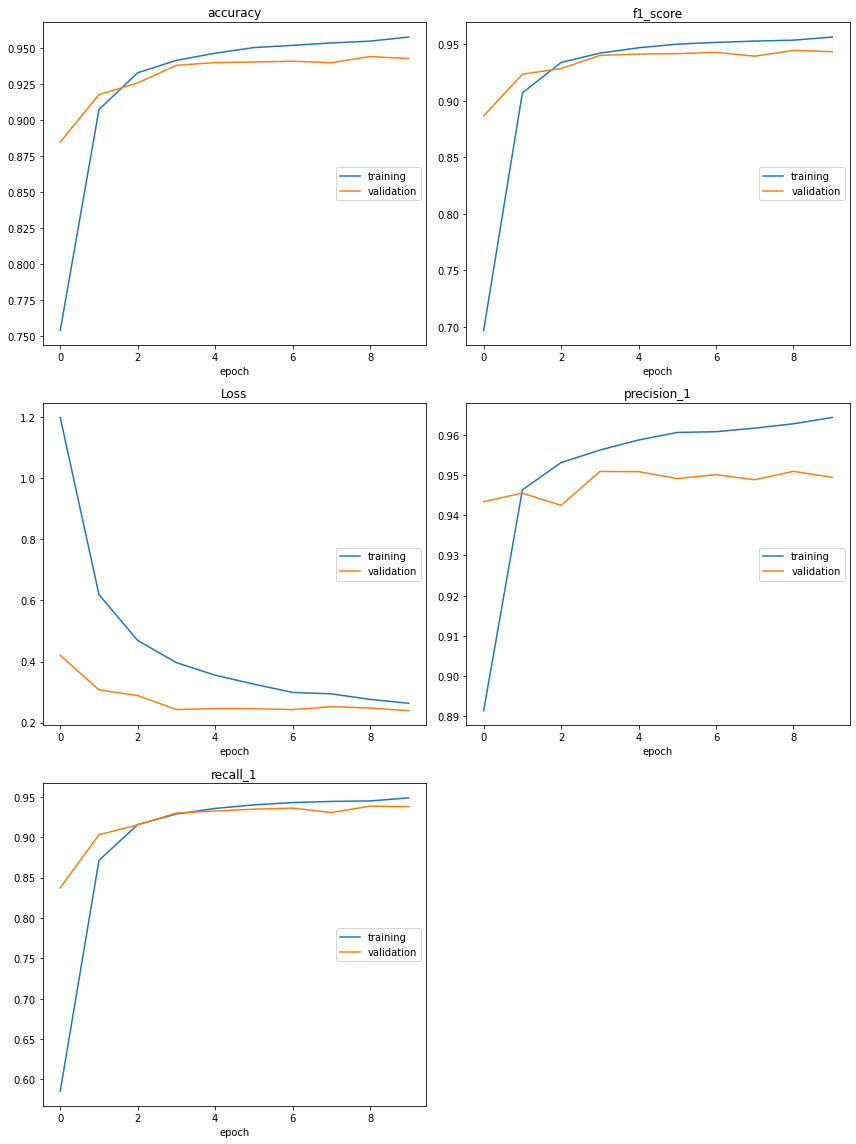

accuracy
	training         	 (min:    0.754, max:    0.957, cur:    0.957)
	validation       	 (min:    0.885, max:    0.944, cur:    0.943)
f1_score
	training         	 (min:    0.697, max:    0.956, cur:    0.956)
	validation       	 (min:    0.887, max:    0.945, cur:    0.943)
Loss
	training         	 (min:    0.263, max:    1.199, cur:    0.263)
	validation       	 (min:    0.239, max:    0.420, cur:    0.239)
precision_1
	training         	 (min:    0.891, max:    0.964, cur:    0.964)
	validation       	 (min:    0.942, max:    0.951, cur:    0.949)
recall_1
	training         	 (min:    0.586, max:    0.949, cur:    0.949)
	validation       	 (min:    0.837, max:    0.938, cur:    0.938)
796/796 [==============================] - 66s 82ms/step - loss: 0.2633 - accuracy: 0.9575 - precision_1: 0.9643 - recall_1: 0.9487 - f1_score: 0.9564 - val_loss: 0.2388 - val_accuracy: 0.9425 - val_precision_1: 0.9494 - val_recall_1: 0.9378 - val_f1_score: 0.9435 - lr: 0.0010
Epoch 11/60
110/79

KeyboardInterrupt: ignored

In [70]:
history = model.fit(train_words, train_entities,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=[testa_words, testa_entities],
                    class_weight=class_weights,
                    callbacks=call_backs,
                    verbose=1)

In [71]:
model.load_weights("/content/bilstm_best_model_weights.h5")

In [72]:
model.evaluate(testa_words, testa_entities)

1606/1606 [==============================] - 23s 15ms/step - loss: 0.2478 - accuracy: 0.9440 - precision_1: 0.9509 - recall_1: 0.9384 - f1_score: 0.9443


[0.2478005439043045,
 0.9439858198165894,
 0.9509341716766357,
 0.9384369850158691,
 0.9443498253822327]

In [120]:
y_hat = model.predict(testa_words)
y_hat = np.argmax(y_hat, axis=1)

In [121]:
entity_count(testa_entity)
accuracy(np.argmax(testa_entities, axis=1), y_hat)

ORG: 2092
PER: 3149
LOC: 2094
MISC: 1268
O: 42759
accuracy = 48485 / 51362 = 0.943986


Accuracy:  0.9439858260971146
Precision::  0.9439858260971146
Recall::  0.9439858260971146
F1_Score::  0.9439858260971147

Macro precision_recall_fscore_support (macro) average
(0.8222263611067282, 0.7616314064478722, 0.7895861975238174, None)

Macro precision_recall_fscore_support (micro) average
(0.9439858260971146, 0.9439858260971146, 0.9439858260971147, None)

Macro precision_recall_fscore_support (weighted) average
(0.9404303668633371, 0.9439858260971146, 0.9416993752941931, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

         LOC       0.82      0.76      0.79      2270
        MISC       0.78      0.64      0.70      1557
           O       0.97      0.99      0.98     41880
         ORG       0.67      0.59      0.63      2376
         PER       0.86      0.82      0.84      3279

    accuracy                           0.94     51362
   macro avg       0.82      0.76      0.79     51362
weighted avg       0.94      0.94 

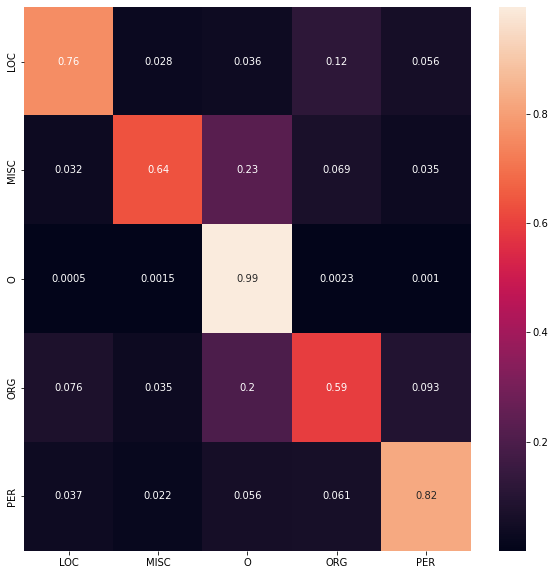

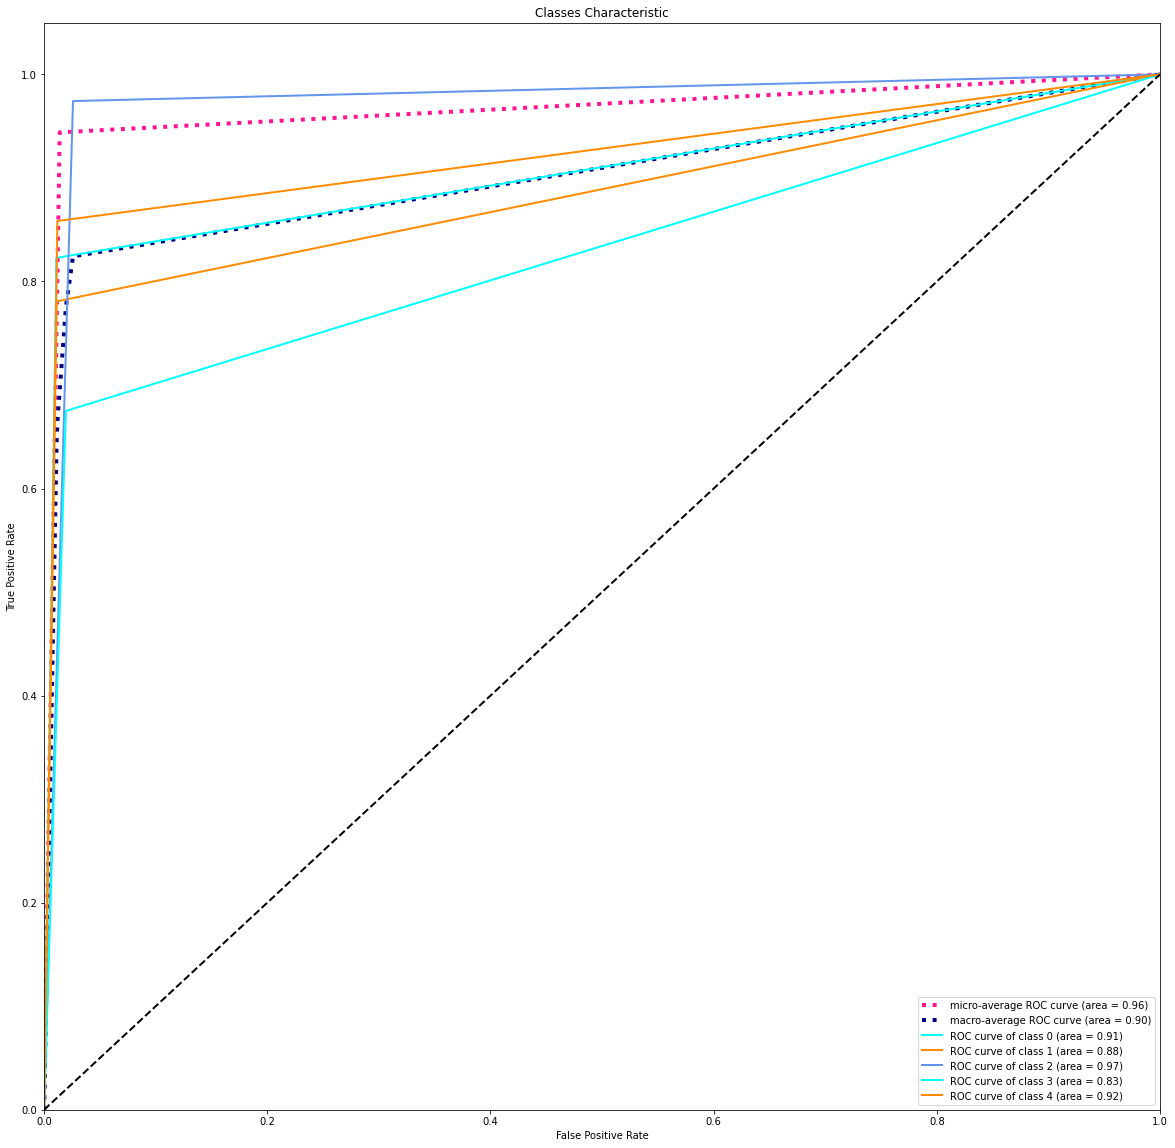

In [109]:
print_score(np.argmax(testa_entities, axis=1), y_hat , label_to_int)

y_hat_ohe = np.eye(np.max(y_hat) + 1)[y_hat] 

ROC_plot(testa_entities, y_hat_ohe, int_to_label, len(labels))

Accuracy:  0.9233121567782923
Precision::  0.9233121567782923
Recall::  0.9233121567782923
F1_Score::  0.9233121567782924

Macro precision_recall_fscore_support (macro) average
(0.7918533546070431, 0.6978096610156143, 0.7370037534889484, None)

Macro precision_recall_fscore_support (micro) average
(0.9233121567782923, 0.9233121567782923, 0.9233121567782924, None)

Macro precision_recall_fscore_support (weighted) average
(0.9173205001906812, 0.9233121567782923, 0.9186976971286865, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

         LOC       0.80      0.67      0.73      2307
        MISC       0.78      0.50      0.61      1426
           O       0.96      1.00      0.98     37029
         ORG       0.63      0.55      0.59      2850
         PER       0.78      0.77      0.77      2823

    accuracy                           0.92     46435
   macro avg       0.79      0.70      0.74     46435
weighted avg       0.92      0.92 

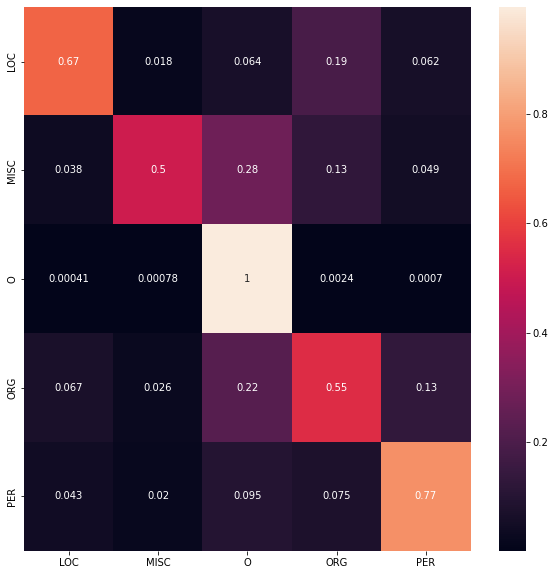

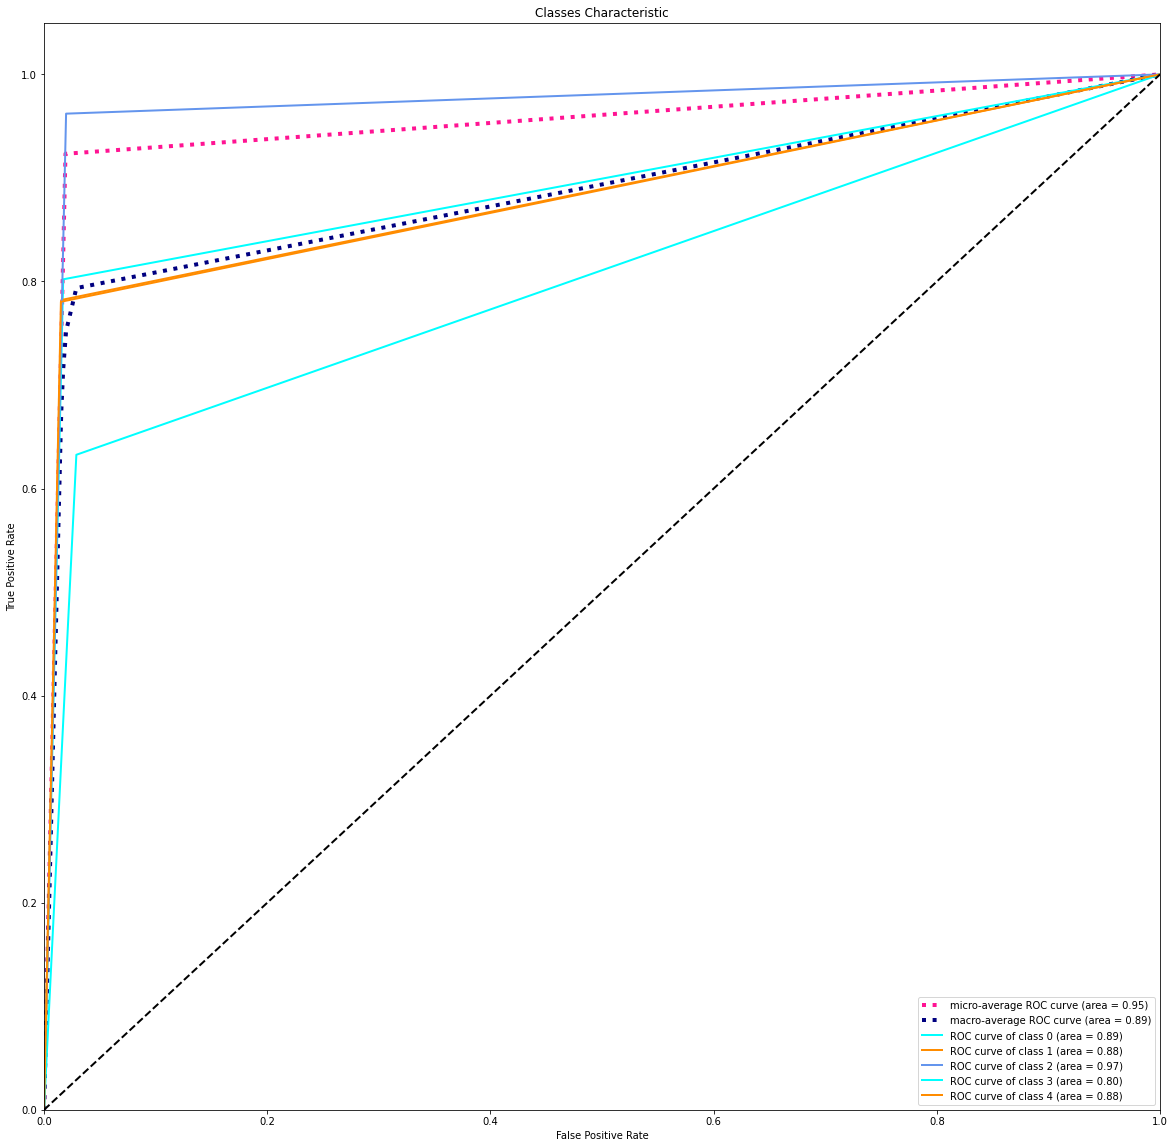

In [110]:
y_hat = model.predict(testb_words)
y_hat = np.argmax(y_hat, axis=1)

print_score(np.argmax(testb_entities, axis=1), y_hat , label_to_int)

y_hat_ohe = np.eye(np.max(y_hat) + 1)[y_hat] 

ROC_plot(testb_entities, y_hat_ohe, int_to_label, len(labels))

Accuracy:  0.9142857142857143
Precision::  0.9142857142857143
Recall::  0.9142857142857143
F1_Score::  0.9142857142857143

Macro precision_recall_fscore_support (macro) average
(0.6862068965517241, 0.6666666666666666, 0.6728571428571428, None)

Macro precision_recall_fscore_support (micro) average
(0.9142857142857143, 0.9142857142857143, 0.9142857142857143, None)

Macro precision_recall_fscore_support (weighted) average
(0.8753694581280788, 0.9142857142857143, 0.8924489795918367, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00         1
        MISC       0.50      0.33      0.40         3
           O       0.93      1.00      0.96        27
         ORG       1.00      1.00      1.00         2
         PER       1.00      1.00      1.00         2

    accuracy                           0.91        35
   macro avg       0.69      0.67      0.67        35
weighted avg       0.88      0.91 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

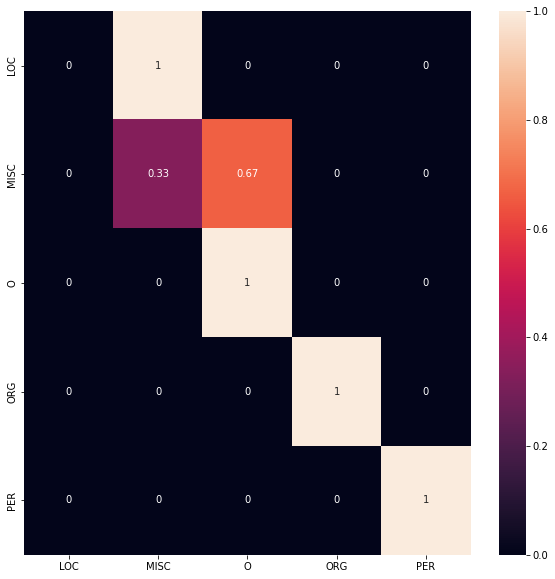

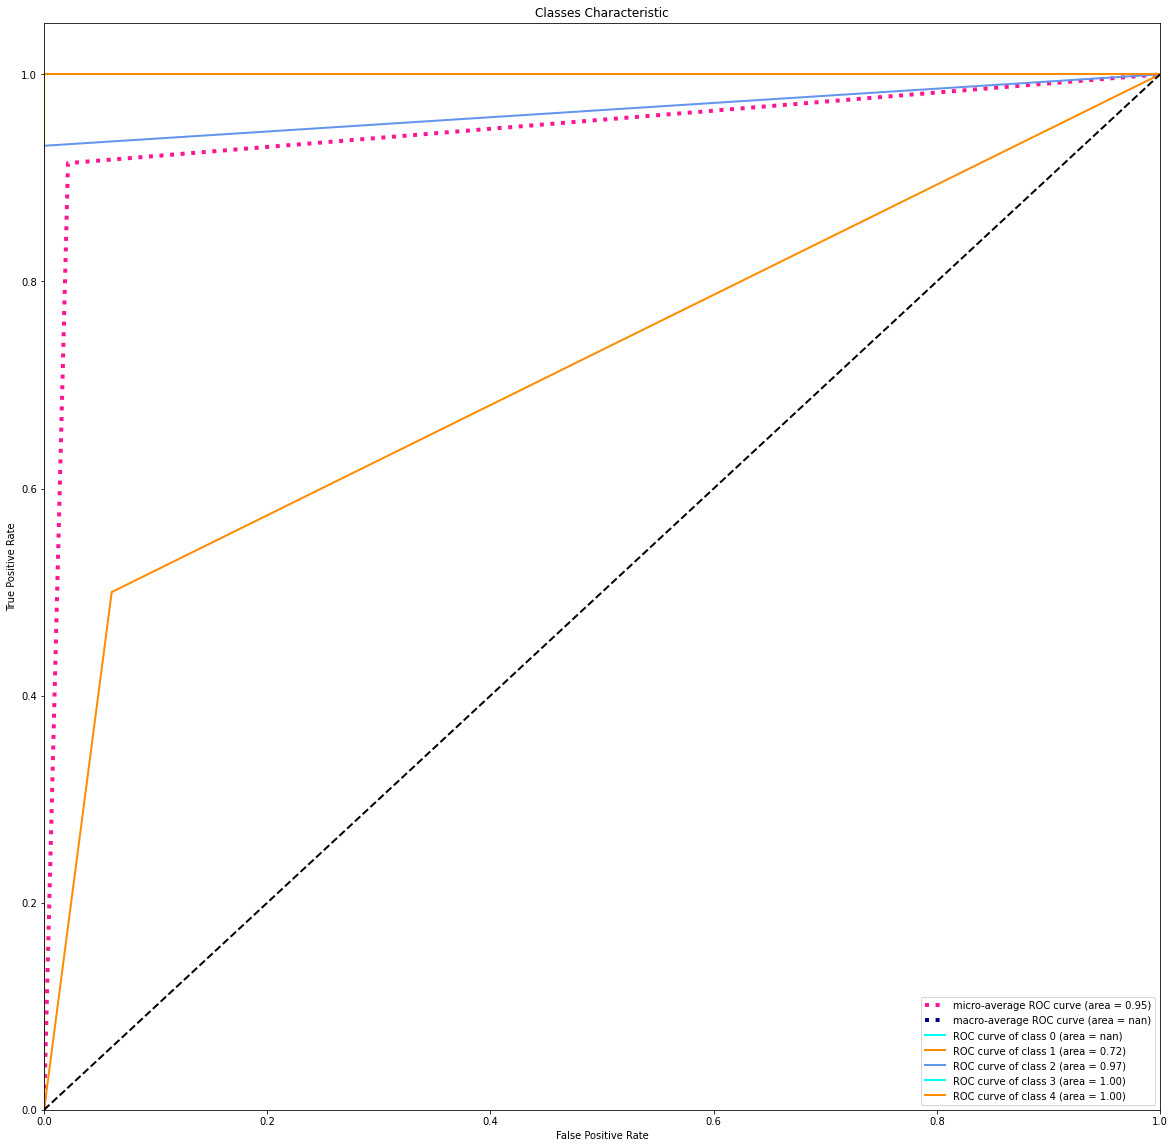

In [111]:
y_hat = model.predict(testc_words)
y_hat = np.argmax(y_hat, axis=1)

print_score(np.argmax(testc_entities, axis=1), y_hat , label_to_int)

y_hat_ohe = np.eye(np.max(y_hat) + 1)[y_hat] 

ROC_plot(testc_entities, y_hat_ohe, int_to_label, len(labels))